## Model analysis and hyper parameter tuning


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GroupKFold

from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import LearningCurve
from yellowbrick.model_selection import FeatureImportances

from sklearn.model_selection import RandomizedSearchCV
from matplotlib.legend_handler import HandlerLine2D

from sklearn.metrics import roc_curve, auc

from pprint import pprint



%matplotlib inline
pd.set_option('display.max_columns', 55)

c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
myTree = DecisionTreeClassifier(random_state = 91)

print('Defaults arameters:')
pprint(myTree.get_params())


Defaults arameters:
{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 91,
 'splitter': 'best'}


In [3]:
#read in csv
df = pd.read_csv("eda.csv")

In [4]:
features = df[[
    'x', 
    'y',
    'dayofweek', 
    'sin_day', 
    'cos_day',
    'sin_year', 
    'cos_year', 
    'TEMP', 
    'cos_wind', 
    'sin_wind', 
    'Wind-Rate', 
    'DEW', 
    'SKY', 
    'VIS', 
    'ATM'
]].astype(np.float64)

features.loc[:,'dayofweek'] = features['dayofweek'].astype('category')

labels = df[[
    'pm25',
    'AQI_VALUE', #pm25 transformed using EPA methodology See DATA Wrangling notebook
    'AQI_class'  #pm25 transformed into EPA categorical class  See DATA Wrangling notebook
]]
labels.loc[:,"polluted"] = (labels.loc[:,"AQI_class"] != "Good")

y = labels['polluted'].values
y = LabelEncoder().fit_transform(y)
X=features

gs = df[['station_id']]

def tts_gs(X, y, gs, test_size):
    stations = gs["station_id"].unique()
    nb_stations = len(stations) * test_size
    my_randoms = random.sample(list(stations), int(nb_stations))
    filters = gs["station_id"].isin(my_randoms)
    print('Substations selected for testing are : ')
    print(my_randoms)
    return X[~filters], X[filters], y[~filters], y[filters], gs[~filters], gs[filters]


numericColumns = ['x','y',
    'dayofweek', 'sin_day', 'cos_day', 'sin_year', 'cos_year', 
    'TEMP', 'cos_wind', 'sin_wind', 'Wind-Rate', 'DEW', 'SKY', 'VIS',  'ATM'
    ]
categoricalColumns = ['dayofweek']

numeric_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


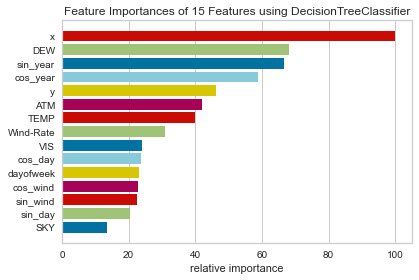

In [5]:
viz = FeatureImportances(myTree)
viz.fit(X, y)
viz.show()

## VIS variable seems not to be important, thus will be removed from the model to simplify it

In [6]:
features = df[[
    'x', 
    'y',
    'dayofweek', 
    'sin_day', 
    'cos_day',
    'sin_year', 
    'cos_year', 
    'TEMP', 
    'cos_wind', 
    'sin_wind', 
    'Wind-Rate', 
    'DEW', 
    'SKY', 
    'ATM'
]].astype(np.float64)

features.loc[:,'dayofweek'] = features['dayofweek'].astype('category')

labels = df[[
    'pm25',
    'AQI_VALUE', #pm25 transformed using EPA methodology See DATA Wrangling notebook
    'AQI_class'  #pm25 transformed into EPA categorical class  See DATA Wrangling notebook
]]
labels.loc[:,"polluted"] = (labels.loc[:,"AQI_class"] != "Good")

y = labels['polluted'].values
y = LabelEncoder().fit_transform(y)
X=features

gs = df[['station_id']]



numericColumns = ['x','y',
    'dayofweek', 'sin_day', 'cos_day', 'sin_year', 'cos_year', 
    'TEMP', 'cos_wind', 'sin_wind', 'Wind-Rate', 'DEW', 'SKY', 'ATM'
    ]
categoricalColumns = ['dayofweek']

numeric_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


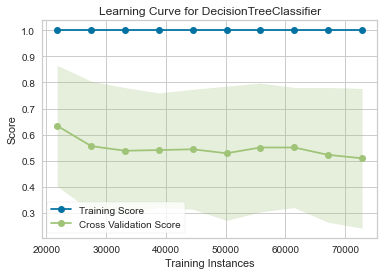

c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


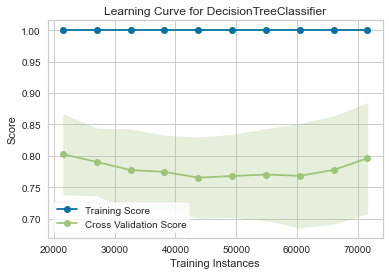

In [7]:
# Create the learning curve visualizer
cv = StratifiedKFold(n_splits=12)
sizes = np.linspace(0.3, 1.0, 10)

# Instantiate the classification model and visualizer

visualizer = LearningCurve(
    myTree, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

groups = gs["station_id"].astype('category').cat.codes.tolist()
gkf = GroupKFold(n_splits=13)

    
# Create the learning curve visualizer
cv = gkf.split(X, y, groups=groups)
sizes = np.linspace(0.3, 1.0, 10)

# Instantiate the classification model and visualizer

visualizer = LearningCurve(
    myTree, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)
visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

## The 2 learning curves demostrate the impact / need to use a specific strategy of CV test train split strategy.

## Max depth hyperparameter:

From https://medium.com/@mohtedibf/indepth-parameter-tuning-for-decision-tree-6753118a03c3

### max_depth

The first parameter to tune is max_depth. This indicates how deep the tree can be. The deeper the tree, the more splits it has and it captures more information about the data. We fit a decision tree with depths ranging from 1 to 32 and plot the training and test auc scores.

Substations selected for testing are : 
['VA_EPA', 'MA_EPA_1']


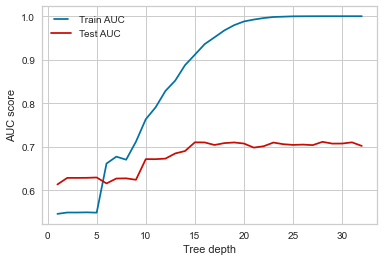

In [8]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []

X_train, X_test, y_train, y_test, gs_train, gs_test = tts_gs(X, y, gs, test_size=0.2)

for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous train results
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous test results
    test_results.append(roc_auc)
    

line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

From https://medium.com/@mohtedibf/indepth-parameter-tuning-for-decision-tree-6753118a03c3

### min_samples_split

min_samples_split represents the minimum number of samples required to split an internal node. This can vary between considering at least one sample at each node to considering all of the samples at each node. When we increase this parameter, the tree becomes more constrained as it has to consider more samples at each node. Here we will vary the parameter from 10% to 100% of the samples

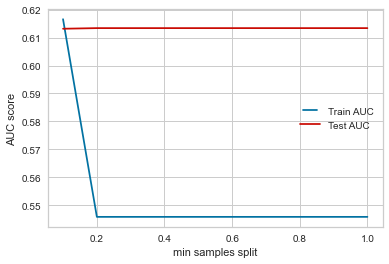

In [9]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []

for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds =    roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    


line1, = plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()

From https://medium.com/@mohtedibf/indepth-parameter-tuning-for-decision-tree-6753118a03c3

### min_samples_leaf

min_samples_leaf is The minimum number of samples required to be at a leaf node. This parameter is similar to min_samples_splits, however, this describe the minimum number of samples of samples at the leafs, the base of the tree.

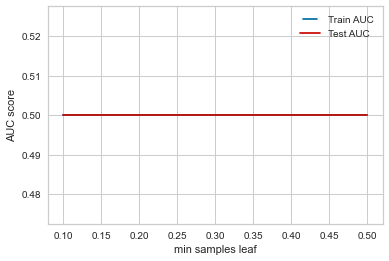

In [10]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()

From https://medium.com/@mohtedibf/indepth-parameter-tuning-for-decision-tree-6753118a03c3

### max_features

max_features represents the number of features to consider when looking for the best split.

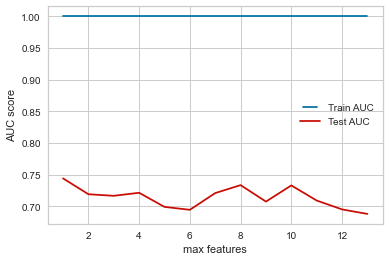

In [11]:
max_features = list(range(1,X_train.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
    dt = DecisionTreeClassifier(max_features=max_feature)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_features, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.show()

## Pre Conclusions

Good parameters seems to be
* max_feature of 8
* min_samples_leafs to default
* min_samples_splits to .1 or lower
* max_depth about 10 or 11


## Let s try to add cirterion and run them all

In [12]:
myTree = DecisionTreeClassifier(random_state = 91)

print('Defaults arameters:')
pprint(myTree.get_params())

Defaults arameters:
{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 91,
 'splitter': 'best'}


In [13]:
max_features = list(range(1,X_train.shape[1]))
criterion = ['gini', 'entropy']
min_samples_leaf = np.linspace(0.1, 0.5, 5, endpoint=True)
min_samples_split = np.linspace(0.1, 1.0, 10, endpoint=True)
max_depth = np.linspace(1, 32, 32, endpoint=True)

random_grid = {'estimator__max_features': max_features,
               'estimator__criterion': criterion,
               #'estimator__min_samples_leaf': min_samples_leaf,
               #'estimator__min_samples_split': min_samples_split,
               #'estimator__max_depth': max_depth
              }

pprint(random_grid)

{'estimator__criterion': ['gini', 'entropy'],
 'estimator__max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]}


In [14]:
# Use the random grid to search for best hyperparameters
numeric_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

#categorical_features = categoricalColumns
categorical_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

model = Pipeline([
     ("ColumnTransformer", ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numericColumns),
            ('cat', categorical_transformer, categoricalColumns)
        ])),
     ('estimator', DecisionTreeClassifier(random_state = 91))
])


groups = gs_train["station_id"].astype('category').cat.codes.tolist()
gkf = GroupKFold(n_splits=len(gs_train["station_id"].unique().tolist()))
    
# Create the learning curve visualizer
cv = gkf.split(X_train, y_train, groups=groups)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 200, cv = cv, verbose=2, random_state=91, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)


Fitting 12 folds for each of 26 candidates, totalling 312 fits


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 26 is smaller than n_iter=200. Running 26 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 312 out of 312 | elapsed:   27.2s finished


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x000001AC4CC7D4A0>,
                   estimator=Pipeline(steps=[('ColumnTransformer',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['x',
                                                                                'y',
                                                                                'dayofweek',
                                                                                'sin_day',
                                                                                'cos_day',
                                                                                'sin_year',
      

In [15]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = sum(predictions != test_labels)
    trues = sum((test_labels == True))
    falses = sum((test_labels == False))
    true_positives = sum((predictions == test_labels) & (test_labels == True))
    true_negatives = sum((predictions == test_labels) & (test_labels == False))
    false_positives = sum((predictions != test_labels) & (test_labels == True))
    false_negatives = sum((predictions != test_labels) & (test_labels == False))
    
    print('Model Performance')
    print('Average Error: {:0.4f}.'.format(errors / len(test_labels)))
    print('Average true_positives: {:0.4f}.'.format(true_positives / len(test_labels)))
    print('Average true_negatives: {:0.4f}.'.format(true_negatives / len(test_labels)))
    print('Average false_positives: {:0.4f}.'.format(false_positives / len(test_labels)))
    print('Average false_negatives: {:0.4f}.'.format(errors / len(test_labels)))
    
    #Precision = TruePositives / (TruePositives + FalsePositives)
    trues_precision = (true_positives / (true_positives + false_positives))
    falses_precision = (true_negatives / (true_negatives + false_negatives))
    print('Precision for Trues (is Polluted) = {:0.4f}%.'.format(100*trues_precision))
    print('Precision for False (not Polluted) {:0.24}%.'.format(100*falses_precision))
    
    #Recall = TruePositives / (TruePositives + FalseNegatives)
    trues_recall = true_positives / (true_positives + false_negatives)
    falses_recall = true_negatives / (true_negatives + false_positives)
    print('(!)Precision for Trues (is Polluted) = {:0.4f}%.'.format(100*trues_recall))
    print('Precision for False (not Polluted) {:0.4f}%.'.format(100*falses_recall))
    
    #F-1 = (2 * Precision * Recall) / (Precision + Recall)
    trues_f1 = (2 * trues_precision * trues_recall) /(trues_precision + trues_recall)
    falses_f1 = (2 * falses_precision * falses_recall) /(falses_precision + falses_recall)
    print('(!)F1 for Trues (is Polluted) = {:0.4f}%.'.format(100*trues_f1))
    print('F1 for False (not Polluted) {:0.4f}%.'.format(100*falses_f1))
    
    # Compute and return F1 (harmonic mean of precision and recall)
    print("{}: {:0.4f}%".format(model.__class__.__name__, 100 * f1_score(test_labels, predictions)))
    
    return f1_score(test_labels, predictions)

In [16]:
myTree.fit(X_train, y_train)
base_accuracy = evaluate(myTree, X_test, y_test)

Model Performance
Average Error: 0.1168.
Average true_positives: 0.0236.
Average true_negatives: 0.8597.
Average false_positives: 0.0219.
Average false_negatives: 0.1168.
Precision for Trues (is Polluted) = 51.8692%.
Precision for False (not Polluted) 90.0608218365227770618731%.
(!)Precision for Trues (is Polluted) = 19.9044%.
Precision for False (not Polluted) 97.5183%.
(!)F1 for Trues (is Polluted) = 28.7689%.
F1 for False (not Polluted) 93.6413%.
DecisionTreeClassifier: 28.7689%


In [17]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

Model Performance
Average Error: 0.1558.
Average true_positives: 0.0299.
Average true_negatives: 0.8143.
Average false_positives: 0.0155.
Average false_negatives: 0.1558.
Precision for Trues (is Polluted) = 65.8879%.
Precision for False (not Polluted) 85.3063343717549287248403%.
(!)Precision for Trues (is Polluted) = 17.5957%.
Precision for False (not Polluted) 98.1314%.
(!)F1 for Trues (is Polluted) = 27.7741%.
F1 for False (not Polluted) 91.2705%.
Pipeline: 27.7741%


In [18]:
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Improvement of -3.46%.


In [19]:
rf_random.best_params_

{'estimator__max_features': 5, 'estimator__criterion': 'entropy'}

In [20]:
from sklearn.externals import joblib

joblib.dump(rf_random.best_estimator_, 'bestTree.model')

ImportError: cannot import name 'joblib' from 'sklearn.externals' (c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\externals\__init__.py)

### Building an app

Just a first exploratory step to see how far it is simple using javascript export from sklearn_porter

https://github.com/nok/sklearn-porter

In [21]:
from sklearn_porter import Porter
# Export:
porter = Porter(myTree, language='js')
output = porter.export(embed_data=True)
print(output)

c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)
c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.weight_boosting module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sk

var DecisionTreeClassifier = function() {

    var findMax = function(nums) {
        var index = 0;
        for (var i = 0; i < nums.length; i++) {
            index = nums[i] > nums[index] ? i : index;
        }
        return index;
    };

    this.predict = function(features) {
        var classes = new Array(2);
            
        if (features[6] <= 0.9804328382015228) {
            if (features[0] <= 38.9217414855957) {
                if (features[11] <= 18.179999351501465) {
                    if (features[6] <= 0.3816750794649124) {
                        if (features[5] <= 0.3856491148471832) {
                            if (features[7] <= 34.73500061035156) {
                                if (features[0] <= 38.897891998291016) {
                                    if (features[1] <= -76.97306442260742) {
                                        if (features[0] <= 38.879066467285156) {
                                            if (features[8] <= -0.704416036605835) {